# VISTA VIKING / HSC WIDE run

In this directory we are job dictionaries for a processing of VIKING J,Ks and HSC G,R,I,Z,Y PDR2 WIDE data. this exists on the W03 and W04 fields


In this notebook we plot the VIKING tiles, over the tracts to patches to check coverages and then create the slurm jobs required to send the jobs to IRIS as arrays. 

In [1]:
from astropy.table import Table,Column
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import json

#We are using a rings skymap
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

config = RingsSkyMapConfig()
#These config options are chose to be the same as HSC:
#https://github.com/lsst/obs_subaru/blob/master/config/hsc/makeSkyMap.py
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0/60 
config.pixelScale = 0.168
sm = RingsSkyMap(config)

In [2]:
WORK_DIR='/home/ir-shir1/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu4/dmu4_VIKING/slurm'

In [3]:
viking_ims = Table.read('../../dmu1/data/viking_images_overview_20201218.csv')
hsc_ims = Table.read('../../dmu1/data/hsc_images_overview.csv')

In [4]:
viking_ims[-5:]

file,ra,dec,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,filter,size,visit,exptime,hash
str99,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,int64,int64,int64,str32
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIKING/20141013/v20141013_00339.fit,332.798575,-30.57608,332.0548030361529,332.27590835307427,332.0521446352211,332.2740566428079,-30.06793449485383,-30.067529129238366,-30.25982294299363,-30.259887033324027,Y,72017280,46459,50,018dfa7a4d139004460dd9aadb587b38
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIKING/20141013/v20141013_00475.fit,26.052108,-34.26399,25.277818693328275,25.507970784214024,25.2748504984245,25.50591126864235,-33.75560950747613,-33.75534118954136,-33.94749588769118,-33.94769815183036,Z,67204800,46595,60,b0fb41001668ad8549e6569bb244bad0
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIKING/20141013/v20141013_00329.fit,332.806971,-30.39086,332.0645740252362,332.28526749945286,332.0619351952411,332.28343068415205,-29.882746802828503,-29.8823302305486,-30.07463540203813,-30.074688216801714,Y,71830080,46449,50,5617f8b63f976bbc78f3be4a9064e723
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIKING/20141013/v20141013_00308_st_conf.fit,332.587208,-30.38911,331.8448840314596,332.07204839004163,331.84219703244605,332.0702098318102,-29.880896202374423,-29.880304334268587,-30.07832251436367,-30.078224164277284,J,30821760,46428,25,0c076931ab0fb801acc472a494c7321d
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIKING/20141013/v20141013_00376.fit,342.141529,-27.66843,341.4191022617163,341.63416747880234,341.4162903916366,341.63209186786145,-27.159377254632968,-27.159193713534698,-27.351263186664713,-27.35154943026156,Y,71619840,46496,50,f7892ca69b2f2e34ec4741e154bf93ad


## 1. Plot the regions and compute tile/patch numbers

In [6]:
viking_ims.add_column(Column(
    data= [t.split('/')[-2] for t in viking_ims['file']],
    name='date'))

In [7]:
def fileToNumObs(filename):
    "Parse the file name to an obsNum"
    numObs = filename.split('_')[1].strip('_st_tl_conf.fit')
    return numObs
viking_ims['numObs'] = [fileToNumObs(f) for f in viking_ims['file']]

In [8]:
hsc_ims['tract'] = [f.split('/')[14] for f in hsc_ims['file']]
hsc_ims['patch'] = [f.split('/')[15] for f in hsc_ims['file']]
hsc_ims['depth'] = [f.split('/')[11] for f in hsc_ims['file']]
hsc_ims['band'] = [f.split('-')[-3] for f in hsc_ims['file']]

In [9]:
def fileToType(filename):
    filetype = ''
    types = {
        'tile':'_tl.fit',
        'stack':'_st.fit',
    }
    for k,v in types.items():
        #print(k,v)
        if filename.endswith(v):
            filetype = k
  
    return filetype
viking_ims['type'] = [fileToType(f) for f in viking_ims['file']]

In [10]:
"Out of {} files in VIKING there are {} stack images".format(len(viking_ims),np.sum(viking_ims['type']=='stack'))

'Out of 229841 files in VIKING there are 41615 stack images'

In [11]:
viking_in_wide = viking_ims['dec'] > -5
#viking_in_wide &= viking_ims['ra'] < 41.
#viking_in_wide &= viking_ims['dec'] > -9
#viking_in_wide &= viking_ims['dec'] < 6

viking_ims = viking_ims[viking_in_wide]
"Out of {} VIKING files in the HSC Wide region there are {} stack images in the ra dec limits.".format(
    len(viking_ims), np.sum(viking_ims['type']=='stack'))

/Users/rs548/GitHub/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


'Out of 108262 VIKING files in the HSC Wide region there are 20216 stack images in the ra dec limits.'

In [12]:
viking_ims[:5]

file,ra,dec,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,filter,size,visit,exptime,hash,date,numObs,type
str99,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,int64,int64,int64,str32,str8,str5,str5
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIKING/20150605/v20150605_00215.fit,208.107837,3.47877,207.4630738688919,207.65488832141114,207.46198924317076,207.6540873740008,3.9851989555600147,3.9866076944846855,3.793296491635614,3.794241464569417,H,105292800,229,50,147b9bcb9c6779a3ff8b4e03262492fe,20150605,00215,
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIKING/20150605/v20150605_00231.fit,208.105054,3.476,207.46029274574943,207.65210655122164,207.45920801833822,207.65130553232004,3.9824214314354136,3.983830081281804,3.7905189681032523,3.7914638516737855,J,84931200,245,50,1585c39e236b2073028a0b2f7f52e754,20150605,00231,
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIKING/20150605/v20150605_00185_st.fit,208.106842,3.2994,207.45868542533478,207.65800755073312,207.45796740897393,207.65759738078322,3.8047232552210684,3.806559379806796,3.6051905238391115,3.6065269880930906,Ks,87615360,199,10,6c0f08af65a911c49bb8dcc92ba1ba99,20150605,00185,stack
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIKING/20150605/v20150605_00237_st_conf.fit,208.288546,3.29282,207.64378220251461,207.84105836403262,207.64298762641639,207.84057059346824,3.804075396377622,3.8059751332662977,3.606693032881545,3.6081077556217758,J,28451520,251,25,659c3b4caa4e4ef641653c6a702d9b98,20150605,00237,
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIKING/20150605/v20150605_00237.fit,208.288546,3.29282,207.6439245199214,207.83569666090588,207.64283308401994,207.83489092553174,3.7992613267222937,3.80066410372737,3.607358902562786,3.608297894438862,J,84911040,251,50,b77fd9894c51c98363b32dbb92cc175f,20150605,00237,


In [14]:
np.unique(viking_ims['filter'])

H
J
Ks
Y
Z


In [13]:
"There are {} stack files to process".format(np.sum(viking_ims['type']=='stack'))

'There are 20216 stack files to process'

In [19]:
hsc_bands = ['G', 'R', 'I', 'Z', 'Y']
vista_bands = ['Z', 'Y', 'J', 'H', 'Ks']

In [15]:
#https://hsc-release.mtk.nao.ac.jp/rsrc/pdr2/koike/survey-area/info/tracts_patches_W-w02.txt
patches_file1 = '../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-w03.txt'
patches_file2 = '../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-w04.txt'

In [16]:

tracts = set()

f = open(patches_file1, 'r')
for x in f:
    #print(x)
    
    
    if x.startswith('Tract'):
        #print(int(x.split(' ')[1]))
        tracts.add(int(x.split(' ')[1])) 
        #print('ewrter' , patches, int(x.split(' ')[1]))
    #n+=1
    #if n == 100:
       # break
f = open(patches_file2, 'r')
for x in f:
    #print(x)
    
    
    if x.startswith('Tract'):
        #print(int(x.split(' ')[1]))
        tracts.add(int(x.split(' ')[1]))    

In [17]:

for x in tracts:
    print(x, end=',')

10281,10282,10283,10284,10285,10286,10287,10288,10289,10290,10291,10292,10293,10294,10295,10296,10297,10298,10299,10300,10301,10302,10303,10304,10308,10309,10310,10311,10312,10313,10314,10315,10316,10317,10318,10319,10320,10321,10322,10323,10324,10325,10326,10327,10328,10329,10330,10331,10332,10333,10334,10335,10336,10337,10338,10339,10340,10341,10342,10343,10344,10345,10346,10347,10348,10349,8855,8856,8857,8858,8859,8860,8861,8862,8863,8864,8865,8866,8867,8868,8869,8870,8871,8872,8873,8874,8875,8876,8877,8878,8879,8880,8881,8882,8883,8884,8885,8886,8887,9069,9070,9071,9072,9073,9074,9075,9076,9077,9078,9079,9080,9081,9082,9083,9084,9085,9086,9087,9088,9089,9090,9091,9092,9093,9095,9096,9097,9098,9099,9100,9101,9102,9103,9104,9105,9106,9107,9108,9109,9110,9111,9112,9113,9114,9115,9116,9117,9118,9119,9120,9121,9122,9123,9124,9125,9126,9127,9128,9129,9130,9131,9132,9133,9134,9135,9136,9137,9138,9139,9311,9312,9313,9314,9315,9316,9317,9318,9319,9320,9321,9322,9323,9324,9325,9326,9327,9328

In [20]:
full_patch_dict = {}
band_dict = { hsc_bands[i]: {} for i in range(len(hsc_bands))}
for tract in tracts:
    full_patch_dict[tract] = [
        s for s in np.unique(np.array(hsc_ims[ (hsc_ims['tract'] == str(tract))]['patch']))
    ]
    for band in hsc_bands:
        band_dict[band][tract] = [
            s for s in np.unique(np.array(hsc_ims[
                (hsc_ims['tract'] == str(tract))
                & (hsc_ims['band'] == band)
            ]['patch']))
        ]

In [47]:
json.dumps(full_patch_dict, separators=(',', ':'))

'{"10281":[],"10282":["0,0","0,1","0,2","0,3","0,4","0,5","0,6","1,0","1,1","1,2","1,3","1,4","1,5","2,0","2,1","2,2","2,3","2,4","3,0","3,1","3,2","3,3","4,0","4,1","4,2"],"10283":["0,0","0,1","0,2","0,3","0,4","0,5","0,6","1,0","1,1","1,2","1,3","1,4","1,5","1,6","2,0","2,1","2,2","2,3","2,4","2,5","2,6","3,0","3,1","3,2","3,3","3,4","3,5","3,6","4,0","4,1","4,2","4,3","4,4","4,5","4,6","5,0","5,1","5,2","5,3","5,4","5,5","5,6","6,0","6,1","6,2","6,3","6,4","6,5","6,6","7,0","7,1","7,2","7,3","7,4","7,5","7,6","8,0","8,1","8,2","8,3","8,4","8,5","8,6"],"10284":["0,0","0,1","0,2","0,3","0,4","0,5","0,6","1,0","1,1","1,2","1,3","1,4","1,5","1,6","2,0","2,1","2,2","2,3","2,4","2,5","2,6","3,0","3,1","3,2","3,3","3,4","3,5","3,6","4,0","4,1","4,2","4,3","4,4","4,5","4,6","5,0","5,1","5,2","5,3","5,4","5,5","5,6","6,0","6,1","6,2","6,3","6,4","6,5","6,6","7,0","7,1","7,2","7,3","7,4","7,5","7,6","8,0","8,1","8,2","8,3","8,4","8,5","8,6"],"10285":["0,0","0,1","0,2","0,3","0,4","0,5","0,6",

mkdir: figs: File exists


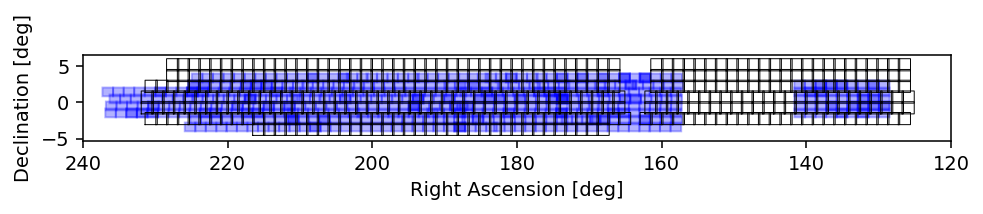

In [23]:
!mkdir figs
fig, ax = plt.subplots(figsize=(8, 1), dpi=140)
for tract in tracts:
    vertices = sm.generateTract(tract).getVertexList()
    ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
    dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
    ax.plot(ra, dec, c = 'k', linewidth=0.5)
    for p in np.nditer(np.meshgrid(np.arange(0,9), np.arange(0,9))):
        #print(p[0], p[1])
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'k', alpha=0.5, linewidth=0.1)

#Plot patches on a band
band = 'all'
if band != 'all':
    d = band_dict[band]
else:
    d = full_patch_dict
for tract in d:
    for patch in d[tract]:
        #print(p[0], p[1])
        p = [int(i) for i in patch.split(',')]
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'r', alpha=1.0, linewidth=0.5)
        

v_band ='Ks'
for t in viking_ims[(viking_ims['type'] == 'tile') & (viking_ims['filter'] == v_band) ]:

    ra = [t['ra_0_0'], t['ra_x_0'] , t['ra_x_y'] , t['ra_0_y'] , t['ra_0_0'] ]
    dec = [t['dec_0_0'], t['dec_x_0'] , t['dec_x_y'] , t['dec_0_y'] , t['dec_0_0'] ]
    
    ax.fill(ra,dec, c = 'b', alpha=0.3)
        
        
        


ax.set_xlim([240, 120])
ax.axis('scaled')
ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination [deg]')
fig.savefig('./figs/viking_HSC-{}_tracts.pdf'.format(band), overwrite=True)
fig.savefig('./figs/viking_HSC-{}_tracts.png'.format(band), overwrite=True)

In [20]:
#How many diferent exposure times for stacks are there
np.unique(viking_ims[(viking_ims['type'] == 'stack') & (viking_ims['filter'] == v_band) ]['exptime'])

7
10


## 1. Make the ProcessCcd array job

We will now create a dictionary mapping integer 0 indexed job ids to job options to reduce the number of slurm files required. This dictionary can then be saved as a json file and passed to the bash script which runs the process. We may wish to move to pure Python but I'm not sure about how parrellelisaion works. 

In [24]:
viking_stacks = viking_ims[(viking_ims['type'] == 'stack')]

In [25]:
viking_stacks[:5]

file,ra,dec,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,filter,size,visit,exptime,hash,date,numObs,type
str99,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,int64,int64,int64,str32,str8,str5,str5
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIKING/20150605/v20150605_00185_st.fit,208.106842,3.2994,207.45868542533478,207.65800755073312,207.45796740897393,207.65759738078322,3.8047232552210684,3.806559379806796,3.6051905238391115,3.6065269880930906,Ks,87615360,199,10,6c0f08af65a911c49bb8dcc92ba1ba99,20150605,00185,stack
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIKING/20150605/v20150605_00229_st.fit,208.105062,3.38441,207.45986158832068,207.6571375789109,207.45911653973323,207.65669866114285,3.8956683052829777,3.8975540487713007,3.698271187515462,3.6996714767300163,J,68690880,243,25,4f2721954d6168b0e9788bf306ced496,20150605,00229,stack
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIKING/20150605/v20150605_00201_st.fit,208.290337,3.39098,207.64241530921794,207.84187793713988,207.64165298189272,207.84142237360808,3.8966683996398563,3.8985224308228448,3.697193984310345,3.6985486607217317,Ks,87857280,215,10,821685ead8e0a7f88a6c0a91eb5fba43,20150605,00201,stack
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIKING/20150605/v20150605_00181_st.fit,214.080475,3.38441,213.4353113885598,213.6326612771985,213.43446291725252,213.63211840439024,3.8956205251134035,3.897339156604706,3.6982576890003536,3.699489914376674,J,72947520,195,25,fff76ab37529cf9ed4c093079b600a29,20150605,00181,stack
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIKING/20150605/v20150605_00147_st.fit,214.082237,3.39098,213.43406195533143,213.63352335470398,213.43328372660974,213.6330519584101,3.896646480603915,3.8983658243477883,3.6971871407257,3.6984062109586113,Ks,88583040,161,10,56df733c275e6226482ef744fd8b4ff3,20150605,00147,stack


In [27]:
np.min([int(d) for d in viking_stacks['date']]), np.max([int(d) for d in viking_stacks['date']])

(20100107, 20180214)

In [28]:
def raDecToTractSafe(ra,dec):
    """Return all the tracts within 2 degrees of a ra dec to get every tract covering a tile
    
    I think the function findTractPatchList excludes all tracts that do not conatin the points
    Crucially this excluded the central tracts. Perhaps we need to get the corners from the tile.
    
    """
    size = 2 #degrees safely outside tile from centre
    patches= sm.findTractPatchList([
        SpherePoint((ra)*degrees,(dec)*degrees)
        for ra, dec in np.nditer(
            np.meshgrid(
                np.linspace(ra+size,ra-size,num=int(size/0.5)),
                np.linspace(dec+size,dec-size,num=int(size/0.5)),
            )
        )
    ])
    tracts = set([p[0].getId() for p in patches])
    t =''
    for n in tracts:
        t += '^{}'.format(n)
    return t[1:]
    
print(viking_stacks[0]['ra'], viking_stacks[0]['dec'],raDecToTractSafe(viking_stacks[0]['ra'],viking_stacks[0]['dec']))

208.106842 3.2994 10336^10337^9608^9609^9610^9611^10092^10093^10094^10095^9850^9851^9852^9853^10334^10335


In [29]:
sm.findAllTracts(SpherePoint(viking_stacks[0]['ra']*degrees,viking_stacks[0]['dec']*degrees))

[TractInfo(id=10094, ctrCoord=[-0.8789164647706941, -0.4725448033666422, 0.06486336998774297])]

In [31]:
processCcd_job_dict = {}

for i in np.arange(len(viking_stacks)):
    date=viking_stacks[i]['date']
    processCcd_job_dict[str(i)] = [
        '{}-{}-{}'.format(date[0:4],date[4:6],date[6:9]),
        viking_stacks[i]['numObs'],
        'VISTA-{}'.format(viking_stacks[i]['filter']),
        raDecToTractSafe(viking_stacks[i]['ra'],viking_stacks[i]['dec']),
        viking_stacks[i]['file']
    ]
    

In [32]:
processCcd_job_dict['0']

['2015-06-05',
 '00185',
 'VISTA-Ks',
 '10336^10337^9608^9609^9610^9611^10092^10093^10094^10095^9850^9851^9852^9853^10334^10335',
 '/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIKING/20150605/v20150605_00185_st.fit']

In [42]:
len(processCcd_job_dict)

20216

In [33]:
with open('./slurm/processCcd_job_dict.json', 'w') as outfile:
    json.dump(processCcd_job_dict, outfile, separators=(',', ':'))

# 2. Make the patch array job dictionary

We need a dictionary of all the patches to allow slurm array submissions.

In [34]:
len(tracts)

443

In [35]:
np.min(viking_stacks['dec']),np.max(viking_stacks['dec'])

(-4.22526, 3.48258)

In [43]:
viking_tracts = set()
for tract in tracts:
    if sm.generateTract(tract).getCtrCoord().getDec().asDegrees() < 4.:
        viking_tracts.add(tract)

In [44]:
len(viking_tracts)

377

In [38]:
patch_job_dict = {}
n=0
for tract in viking_tracts:
    for patch in np.nditer(np.meshgrid(np.arange(9),np.arange(9))):
        patch_job_dict[str(n)]=[tract, "{},{}".format(patch[0],patch[1]), ]
        n+=1

In [39]:
n

19683

In [40]:
patch_job_dict['0']

[9586, '0,0']

In [41]:
with open('./slurm/patch_job_dict.json', 'w') as outfile:
    json.dump(patch_job_dict, outfile, separators=(',', ':'))